# Detecção de Máscara com SSD

O Objetivo desse jupyter notebook é fazer o treinamento de um modelo de CNN capaz de detectar o uso de Máscaras ou não em faces humanas, para isso foi treinado um modelo SSD.


O que é SSD?

SSD é um detector multibox de disparo único. É uma técnica usada para detectar objetos em imagens usando uma única rede neural profunda. Basicamente é usado para detecção de objetos em uma imagem. Ao usar uma arquitetura básica da arquitetura VGG-16, o SSD é capaz de superar outros detectores de objetos, como YOLO e Faster R-CNN, tanto em velocidade quanto em precisão. A arquitetura do SSD é mostrada na figura abaixo. Treinar um modelo SSD do zero exigirá muitos dados, então aqui importei pesos pré-treinados (modelo Caffe Face Detector) usando OpenCV.

![1](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*hdSE1UCV7gA7jzfQ03EnWw.png)

## Montar o drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instalação das versões da libs usadas

In [2]:
!pip install watermark pandas==1.5.3 keras==2.13.1 seaborn==0.12.2 tensorflow==2.13.0 opencv-python==4.8.0 numpy==1.23.5 matplotlib==3.7.1

ERROR: Could not find a version that satisfies the requirement json==2.0.9 (from versions: none)
ERROR: No matching distribution found for json==2.0.9


## Download do dataset

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json


!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset
!unzip /content/face-mask-detection-dataset.zip -d /content/kaggle/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1091.jpg  
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1092.jpg  
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1093.jpg  
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1094.jpg  
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1095.jpg  
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1096.jpg  
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1097.jpg  
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1098.jpg  
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1099.jpg  
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1101.jpg  
  inflating: /content/kaggle/Medical mask/Medical mask/Medical Mask/images/1102.j

## Importação das bibliotecas

In [4]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

## Versao das libs usadas

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Version 0" --iversions

ModuleNotFoundError: ignored

## Caminhos dos datasets

In [6]:
directory = "/content/kaggle/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "/content/kaggle/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("/content/kaggle/train.csv")
df_test = pd.read_csv("/content/kaggle/submission.csv")

## Modelo pré-treinado

A função cv2.dnn.readNetFromCaffe é uma função usada para carregar um modelo de rede neural convolucional (CNN) treinado usando a estrutura Caffe (Convolutional Architecture for Fast Feature Embedding). Esta função é parte do módulo Deep Neural Networks (dnn) do OpenCV, que fornece suporte para trabalhar com redes neurais profundas.

Aqui está uma explicação do que essa função faz e seus principais parâmetros:

* **prototxt**: Este é o caminho para o arquivo de configuração do modelo Caffe (com extensão .prototxt). O arquivo .prototxt contém a arquitetura da rede neural, incluindo camadas, conexões e hiperparâmetros.

* **caffeModel**: Este é o caminho para o arquivo binário que contém os pesos treinados do modelo Caffe (com extensão .caffemodel). Este arquivo contém os parâmetros que foram aprendidos durante o treinamento da rede neural.

A função cv2.dnn.readNetFromCaffe lê esses dois arquivos e cria um objeto de rede neural em que o modelo e os pesos são carregados. Isso permite que você use essa rede neural para fazer inferências em imagens, vídeos ou dados de entrada, dependendo do propósito para o qual a rede foi treinada.

In [24]:
cvNet = cv2.dnn.readNetFromCaffe('/content/drive/MyDrive/FIAP/Deep_Learning/Deteccao_objetos/deploy.prototxt','/content/drive/MyDrive/FIAP/Deep_Learning/Deteccao_objetos/weights.caffemodel')

## Funções auxiliares:


**getJSON**: A função JSON busca o arquivo json que contém os dados da caixa delimitadora no conjunto de dados de treinamento.

**adjust_gamma**:A correção gama, ou muitas vezes simplesmente gama, é uma operação não linear usada para codificar e decodificar valores de luminância ou tristímulos em sistemas de vídeo ou imagem estática.  Em termos simples, é usado para incutir alguma luz na imagem.  Se gama <1, a imagem mudará para a extremidade mais escura do espectro e quando gama> 1, haverá mais luz na imagem.

In [7]:
# Defina uma função chamada 'getJSON' que aceita um argumento 'filePathandName'.
def getJSON(filePathandName):
    # Abra o arquivo especificado em 'filePathandName' no modo de leitura ('r').
    with open(filePathandName, 'r') as f:
        # Carregue o conteúdo do arquivo JSON usando a função 'load' do módulo 'json'.
        # Em seguida, retorne os dados JSON carregados.
        return json.load(f)


In [8]:
# Esta função é chamada 'adjust_gamma' e recebe dois parâmetros:
# 'image' é a imagem de entrada à qual será aplicada uma correção gamma.
# 'gamma' é um parâmetro opcional que define o valor do fator gamma.
def adjust_gamma(image, gamma=1.0):
    # Calcula o inverso do valor de gamma.
    invGamma = 1.0 / gamma

    # Cria uma tabela de consulta (lookup table) que mapeia os valores de pixel da imagem original
    # para os valores de pixel corrigidos com base no valor de gamma fornecido.
    # Para cada valor de pixel de entrada (0 a 255), ele calcula o valor de pixel corrigido e
    # multiplica por 255 para manter a faixa de 0 a 255.
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])

    # Aplica a tabela de consulta para a imagem de entrada.
    # Converte a imagem de entrada e a tabela para o tipo de dados np.uint8 (unsigned int de 8 bits).
    # Em seguida, usa a função cv2.LUT para aplicar a correção gamma à imagem.
    # A imagem resultante é retornada como saída da função.
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


# Pré-processamento de dados

 Vejamos os dados JSON fornecidos para treinamento:

* O campo Anotações contém os dados de todas as faces presentes em uma
determinada imagem.

* Existem vários nomes de classes, mas os verdadeiros nomes de classes são face_with_mask e face_no_mask.

In [ ]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

In [10]:
df = pd.read_csv("/content/kaggle/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


* Ao usar o rótulo de máscara e o rótulo não_máscara, os dados da caixa delimitadora dos arquivos json são extraídos.

* Os rostos de qualquer imagem específica são extraídos e armazenados na lista de dados junto com seu rótulo para o processo de treinamento.

In [26]:
# Cria uma lista vazia chamada "data" que será usada para armazenar os dados processados.
data = []

# Define o tamanho desejado das imagens como 124 pixels.
img_size = 124

# Define duas listas chamadas "mask" e "non_mask" com as classes "face_with_mask" e "face_no_mask".
mask = ['face_with_mask']
non_mask = ["face_no_mask"]

# Cria um dicionário chamado "labels" que mapeia as classes "mask" e "without mask" para os valores 0 e 1, respectivamente.
labels = {'mask': 0, 'without mask': 1}

# Itera sobre os valores únicos na coluna "name" do DataFrame "df".
for i in df["name"].unique():
    # Cria uma string "f" que contém o nome do arquivo JSON correspondente a "i".
    f = i + ".json"

    # Obtém os dados do arquivo JSON usando a função "getJSON" e a concatenação do diretório com o nome do arquivo.
    for j in getJSON(os.path.join(directory, f)).get("Annotations"):
        # Verifica se a classe atual em "j" está na lista "mask".
        if j["classname"] in mask:
            # Extrai as coordenadas da caixa delimitadora (BoundingBox) de "j".
            x, y, w, h = j["BoundingBox"]

            # Lê a imagem correspondente a "i" usando OpenCV.
            img = cv2.imread(os.path.join(image_directory, i), 1)

            # Recorta a imagem com base nas coordenadas da caixa delimitadora.
            img = img[y:h, x:w]

            # Redimensiona a imagem para o tamanho desejado (img_size x img_size).
            img = cv2.resize(img, (img_size, img_size))

            # Adiciona os dados da imagem e a etiqueta correspondente (0 para "mask") à lista "data".
            data.append([img, labels["mask"]])

        # Verifica se a classe atual em "j" está na lista "non_mask".
        if j["classname"] in non_mask:
            # Extrai as coordenadas da caixa delimitadora (BoundingBox) de "j".
            x, y, w, h = j["BoundingBox"]

            # Lê a imagem correspondente a "i" usando OpenCV.
            img = cv2.imread(os.path.join(image_directory, i), 1)

            # Recorta a imagem com base nas coordenadas da caixa delimitadora.
            img = img[y:h, x:w]

            # Redimensiona a imagem para o tamanho desejado (img_size x img_size).
            img = cv2.resize(img, (img_size, img_size))

            # Adiciona os dados da imagem e a etiqueta correspondente (1 para "without mask") à lista "data".
            data.append([img, labels["without mask"]])

# Embaralha os dados na lista "data".
random.shuffle(data)


In [27]:
len(data)

5749

## Dataset treino

In [28]:
X = []
Y = []
for features, label in data:
    X.append(features)
    Y.append(label)

In [29]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

## Modelo

In [30]:
# Importa a classe 'Sequential' da biblioteca Keras, que é usada para criar uma rede neural sequencial.
model = Sequential()

# Adiciona uma camada de convolução 2D com 32 filtros, tamanho do kernel (3, 3), preenchimento 'same',
# função de ativação ReLU e especifica a forma de entrada como (124, 124, 3).
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(124, 124, 3)))

# Adiciona outra camada de convolução 2D com 64 filtros, tamanho do kernel (3, 3) e função de ativação ReLU.
model.add(Conv2D(64, (3, 3), activation='relu'))

# Adiciona mais uma camada de convolução 2D com 128 filtros, tamanho do kernel (3, 3) e função de ativação ReLU.
model.add(Conv2D(128, (3, 3), activation='relu'))

# Adiciona uma camada de MaxPooling 2D com um pool size (2, 2) para reduzir a dimensionalidade espacial.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adiciona uma camada de dropout com uma taxa de 0.25, o que ajuda a prevenir overfitting durante o treinamento.
model.add(Dropout(0.25))

# Achatamento da saída da camada convolucional em um vetor unidimensional.
model.add(Flatten())

# Adiciona outra camada de dropout com uma taxa de 0.5.
model.add(Dropout(0.5))

# Adiciona uma camada densa (fully connected) com 50 unidades e função de ativação ReLU.
model.add(Dense(50, activation='relu'))

# Adiciona mais uma camada de dropout com uma taxa de 0.5.
model.add(Dropout(0.5))

# Adiciona a camada de saída com uma única unidade e função de ativação sigmoid.
model.add(Dense(1, activation='sigmoid'))


In [31]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [32]:
xtrain, xval, ytrain, yval = train_test_split(
    X,
    Y,
    train_size=0.8,
    random_state=0
    )

In [33]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # Não centraliza as médias dos recursos das imagens.
        samplewise_center=False,   # Não centraliza as médias das amostras individuais.
        featurewise_std_normalization=False,  # Não normaliza desvio padrão dos recursos das imagens.
        samplewise_std_normalization=False,   # Não normaliza desvio padrão das amostras individuais.
        zca_whitening=False,        # Não aplica branqueamento ZCA.
        rotation_range=15,          # Permite rotações aleatórias de até 15 graus nas imagens.
        width_shift_range=0.1,     # Permite translação horizontal aleatória de até 10% da largura da imagem.
        height_shift_range=0.1,    # Permite translação vertical aleatória de até 10% da altura da imagem.
        horizontal_flip=True,      # Permite espelhamento horizontal aleatório das imagens.
        vertical_flip=False)       # Não permite espelhamento vertical aleatório das imagens.


datagen.fit(xtrain)

In [35]:
history = model.fit(
    datagen.flow(xtrain, ytrain, batch_size=32),
    steps_per_epoch=xtrain.shape[0]//32,
    epochs=10,
    verbose=1,
    validation_data=(xval, yval)
    )

Epoch 1/10
143/143 [==============================] - 26s 178ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
143/143 [==============================] - 26s 180ms/step - loss: 1.0615e-19 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
143/143 [==============================] - 27s 189ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
143/143 [==============================] - 25s 173ms/step - loss: 3.0415e-27 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
143/143 [==============================] - 26s 179ms/step - loss: 1.2807e-34 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
143/143 [==============================] - 25s 172ms/step - loss: 1.2085e-28 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
143/143 [==============================] - 25s 177ms/step - loss: 0.000

In [ ]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



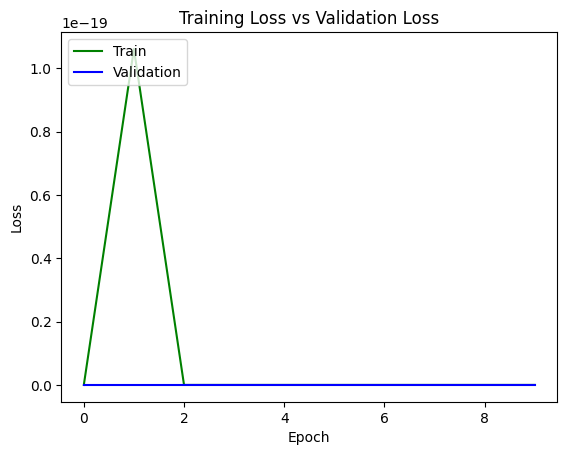

In [37]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Teste
* Correção gama para fazer a imagem aparecer com mais luz. (Gama = 2)

* blobFromImage cria um blob quadridimensional a partir da imagem.  Opcionalmente, redimensiona e corta a imagem do centro, subtrai valores médios, dimensiona valores por fator de escala, troca os canais Azul e Vermelho.  [Consulte a documentação do OpenCV]

* O blob passa pela rede SSD e as detecções são feitas com alguma pontuação de confiança.

* Defina uma pontuação de confiança limite, acima da qual a detecção será considerada candidata a ser um rosto.  (Neste caso, limite de confiança = 0,2)

* Todas as detecções que qualificam a pontuação de confiança são então passadas para a arquitetura para classificação em imagem com ou sem máscara.

1/1 [==============================] - 0s 30ms/step


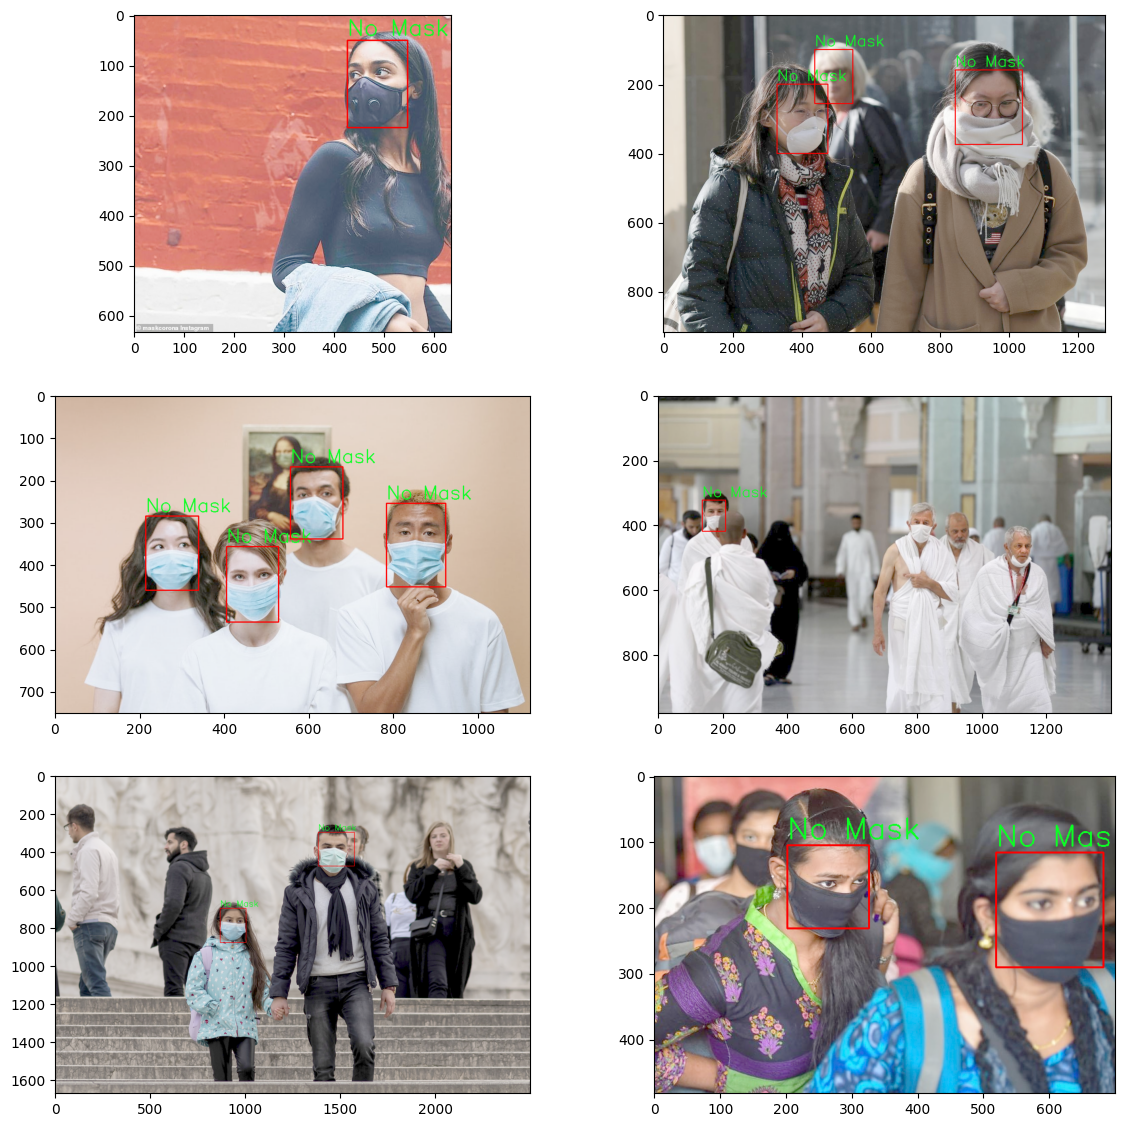

In [38]:
# Lista de nomes de arquivos de imagem a serem processados.
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

# Define o valor do parâmetro gamma para ajuste de brilho.
gamma = 2.0

# Cria uma figura de plotagem com um tamanho específico.
fig = plt.figure(figsize = (14,14))

# Define o número de linhas e colunas para a organização dos gráficos na figura.
rows = 3
cols = 2

# Lista vazia para armazenar os objetos dos eixos dos gráficos.
axes = []

# Dicionário que mapeia os valores de saída do modelo para rótulos ("Mask" ou "No Mask").
assign = {'0':'Mask','1':"No Mask"}

# Itera sobre cada imagem na lista test_images.
for j,im in enumerate(test_images):
    # Lê a imagem do arquivo utilizando OpenCV.
    image = cv2.imread(os.path.join(image_directory,im), 1)

    # Aplica o ajuste de brilho com o valor de gamma especificado.
    image = adjust_gamma(image, gamma=gamma)

    # Obtém a altura (h) e largura (w) da imagem.
    (h, w) = image.shape[:2]

    # Converte a imagem em um blob no formato específico para o modelo de detecção.
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    # Define o blob como entrada para o modelo de detecção.
    cvNet.setInput(blob)

    # Realiza a detecção de objetos na imagem.
    detections = cvNet.forward()

    # Itera sobre os resultados da detecção.
    for i in range(0, detections.shape[2]):
        try:
            # Obtém as coordenadas da caixa delimitadora do objeto detectado.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Recorta a região da imagem contendo o objeto detectado.
            frame = image[startY:endY, startX:endX]

            # Obtém a confiança da detecção.
            confidence = detections[0, 0, i, 2]

            # Verifica se a detecção é confiável o suficiente (confiança maior que 0.2).
            if confidence > 0.2:
                # Redimensiona a região da imagem para o tamanho desejado.
                im = cv2.resize(frame, (img_size, img_size))

                # Normaliza os valores dos pixels da imagem para o intervalo [0, 1].
                im = np.array(im) / 255.0

                # Reorganiza as dimensões da imagem para se adequar ao modelo.
                im = im.reshape(1, 124, 124, 3)

                # Realiza a previsão do modelo na imagem.
                result = model.predict(im)

                # Converte o resultado da previsão em um rótulo.
                if result > 0.5:
                    label_Y = 1
                else:
                    label_Y = 0

                # Desenha a caixa delimitadora e o rótulo na imagem original.
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image, assign[str(label_Y)], (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36, 255, 12), 2)

        except:
            pass

    # Adiciona o eixo correspondente à imagem na lista de eixos.
    axes.append(fig.add_subplot(rows, cols, j+1))

    # Exibe a imagem na posição atual.
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Exibe a figura com todas as imagens processadas.
plt.show()
